<h1><center>Train Image classifier on MNIST with Torchero</h1></center>

## Imports

In [1]:
# Torch #
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim

# Torchvision #
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Torchero #
import torchero
from torchero import SupervisedTrainer
from torchero.callbacks import ProgbarLogger as Logger, ModelCheckpoint, CSVLogger
from torchero.utils import show_imagegrid_dataset

from matplotlib import pyplot as plt

In [2]:
BATCH_SIZE = 300
VAL_BATCH_SIZE = 300
CUDA = True

## Model definition

In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.filter = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2),
                                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2))
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(5*5*64, 500),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(500, 10))

    def forward(self, x):
        x = self.filter(x)
        x = self.linear(x)
        return x

model = Network()

## Load dataset

In [4]:
train_ds = MNIST(root='/tmp/data/mnist', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_ds = MNIST(root='/tmp/data/mnist', download=False, train=False, transform=transforms.Compose([transforms.ToTensor()]))    

### Train dataset examples

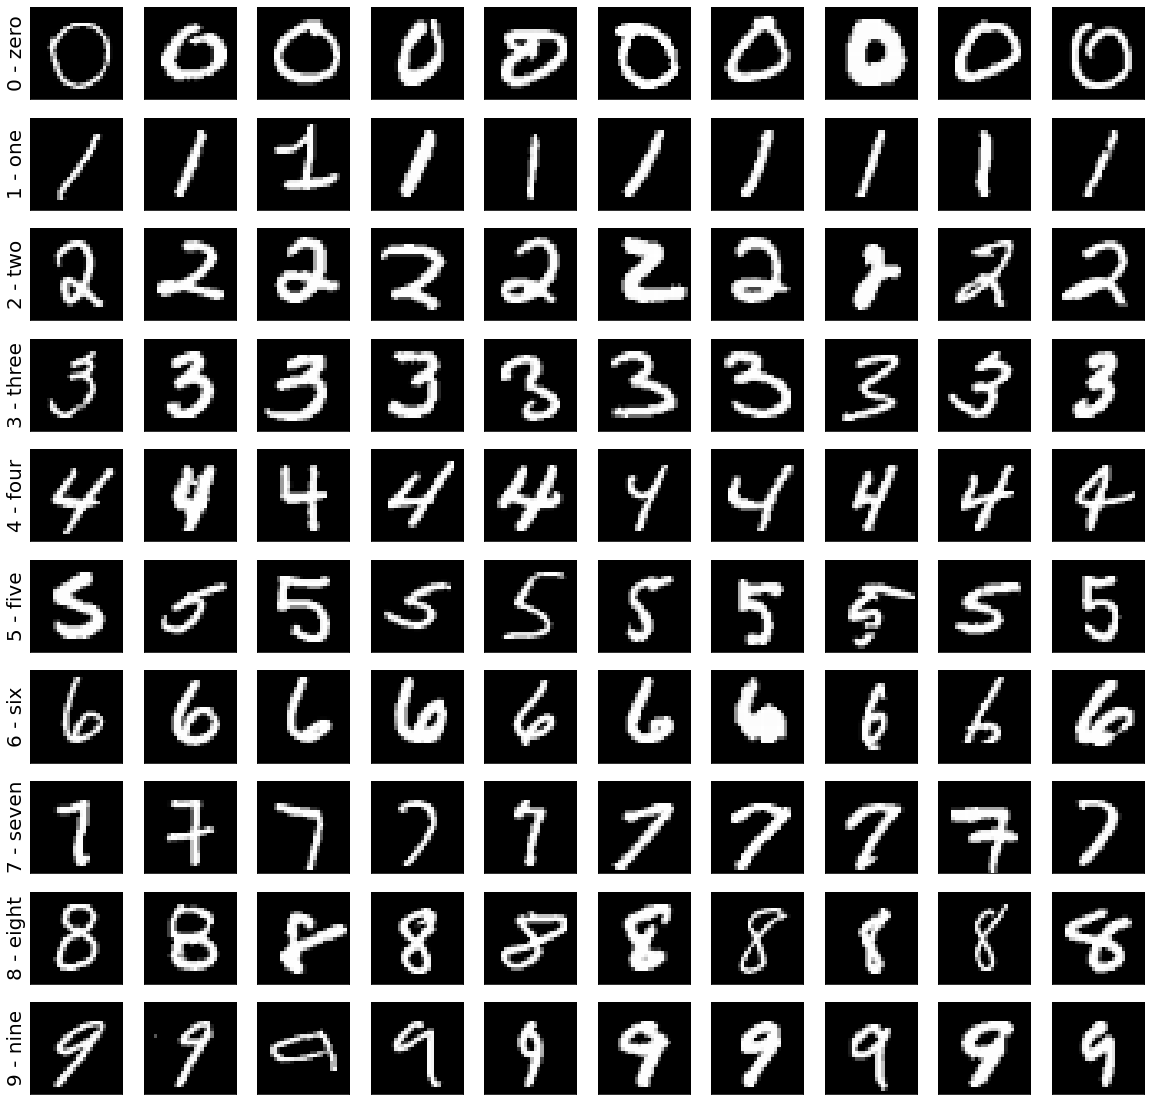

In [5]:
show_imagegrid_dataset(train_ds)
plt.show()

### Test dataset examples

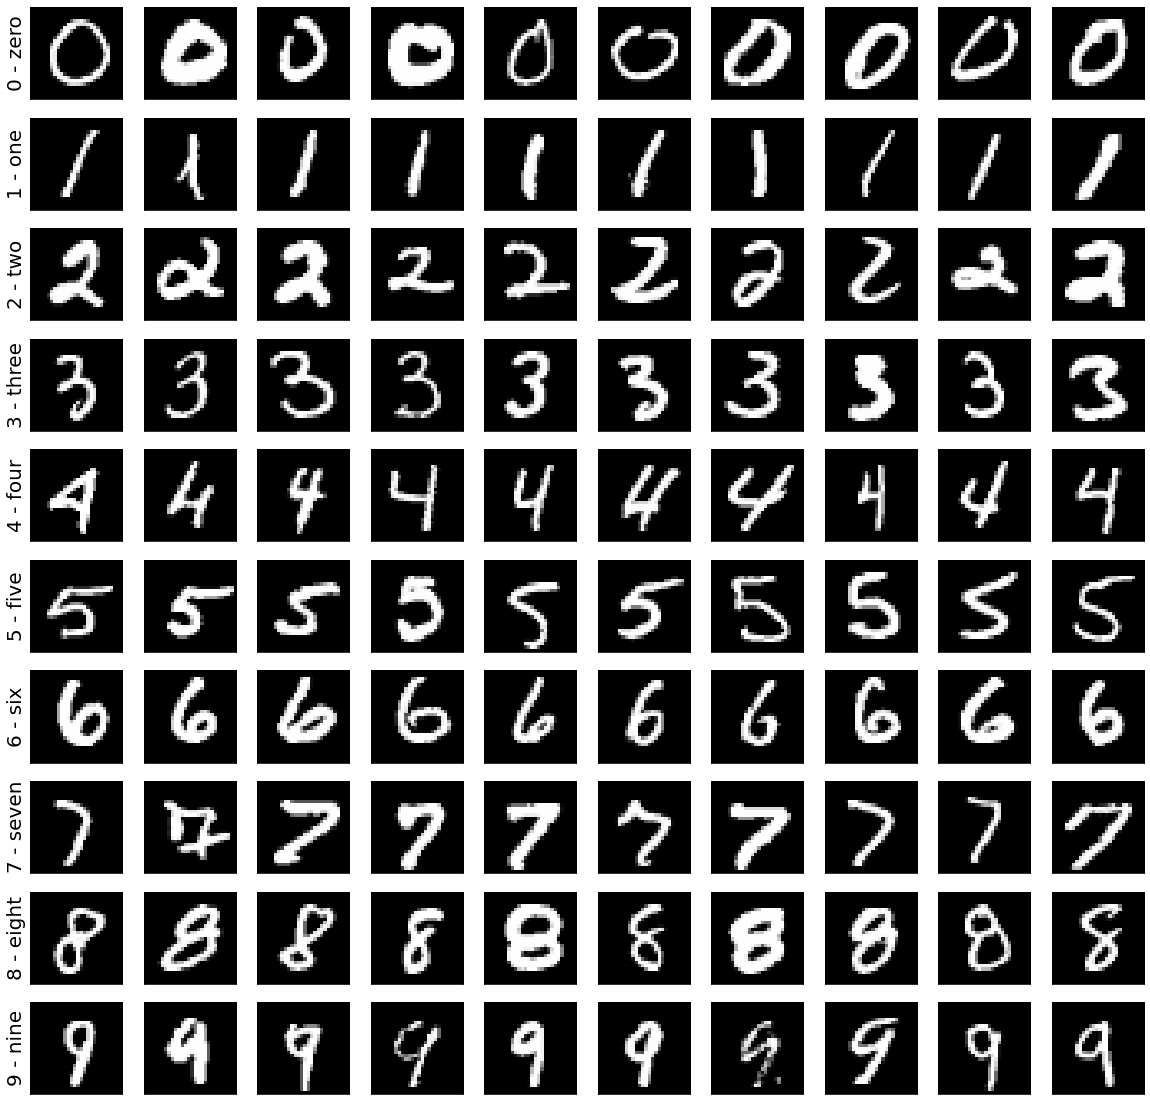

In [6]:
show_imagegrid_dataset(test_ds)
plt.show()

### Setup the DataLoader

In [7]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=VAL_BATCH_SIZE)

## Train

In [8]:
checkpoint = ModelCheckpoint('saved_model', mode='max', monitor='val_acc')
trainer = SupervisedTrainer(model=model,
                            optimizer='sgd',
                            criterion='cross_entropy',
                            acc_meters={'acc': 'categorical_accuracy_percentage'},
                            callbacks=[Logger(notebook=True),
                                       checkpoint,
                                       CSVLogger('training_results.xml')])

In [9]:
if CUDA:
    trainer.cuda()

In [10]:
trainer.train(dataloader=train_dl, valid_dataloader=test_dl, epochs=10)

### Training results

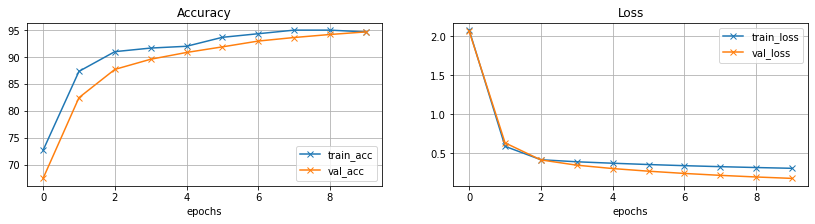

In [11]:
fig, axs = plt.subplots(figsize=(14,3), ncols=2, nrows=1)
trainer.history.epoch_plot(['train_acc', 'val_acc'], ax=axs[0], title="Accuracy")
trainer.history.epoch_plot(['train_loss', 'val_loss'], ax=axs[1], title="Loss")
plt.show()

### Load the best model

In [12]:
checkpoint.load()

/home/chino/Proyectos/Machine Learning/torchero/examples/notebooks/torchero/callbacks/checkpoint.py:72: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f)


{'epoch': 10, 'val_acc': 94.66999816894531}

### Confusion Matrix

In [13]:
results = trainer.evaluate(test_dl, ['categorical_accuracy_percentage', 'confusion_matrix'])

In [14]:
results

{'acc': 94.66999816894531,
 'confusion_matrix': <torchero.meters.confusion_matrix.ResizableConfusionMatrixController at 0x7f276b527160>}

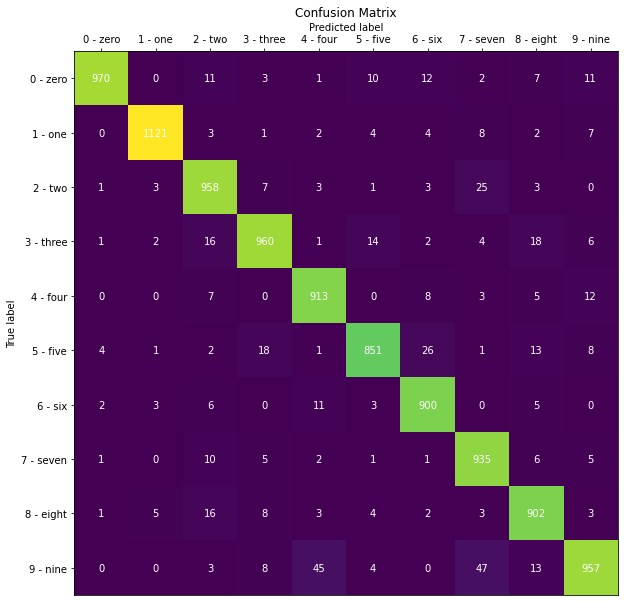

In [15]:
plt.figure(figsize=(10, 10))
results['confusion_matrix'].plot(classes=train_ds.classes)